<div style="width: 100%;text-align:right;display: flex; align-items: top;">
    <div style="float: left;width: 80%;text-align:left">
        <h1>Mass invasion: Temporal patterns for 9 Instagram vantage points in Europe<a class="tocSkip">&#182;</a></h1>
        <p><em><a href="mailto:alexander.dunkel@tu-dresden.de">Alexander Dunkel</a>, Institute of Cartography, TU Dresden</em></p></div>
    <div style="width:256px;text-align:right;margin-top:0px;margin-right:10px"><a href="https://gitlab.hrz.tu-chemnitz.de/ad/ephemeral_events"><img src="https://kartographie.geo.tu-dresden.de/ad/wip/ephemeral_events/version.svg"></a></div>
</div>

In [298]:
from IPython.display import Markdown as md
from datetime import date

today = date.today()
with open('/.version', 'r') as file: app_version = file.read().split("'")[1]
md(f"Last updated: {today.strftime('%b-%d-%Y')}, [Carto-Lab Docker](https://gitlab.vgiscience.de/lbsn/tools/jupyterlab) Version {app_version}")

Last updated: Apr-12-2024, [Carto-Lab Docker](https://gitlab.vgiscience.de/lbsn/tools/jupyterlab) Version 0.14.0

<div style="width:500px">
    
Visualizations of temporal patterns for ephemeral events. This notebook builds upon a  [a previous notebook](https://kartographie.geo.tu-dresden.de/ad/wip/ephemeral_events/html/01_temporal_chi_y.html).

The basis for this notebook are 1.6 Million Tweets that were queried with `cherry AND (flower OR blossom OR sakura)`. The query contains both geotagged and non-geotagged content.

A second query with the same syntax was prepared for Flickr. For Flickr, only geotagged content was considered. This selected `100662` Flickr photographs.

The query period covered for both was `2007` to `2017`.
</div>

# Preparations

In [537]:
import sys, os
import math
import numpy as np
import pandas as pd
import psycopg2
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
import matplotlib.ticker as mticker
from matplotlib.patches import Patch
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.axes import Axes 
from matplotlib import cm
from warnings import warn
from typing import Tuple, Dict, Any
from pathlib import Path
from python_hll.hll import HLL
from python_hll.util import NumberUtil
from shapely.geometry import box
module_path = str(Path.cwd().parents[0] / "py")
if module_path not in sys.path:
    sys.path.append(module_path)
from modules.base import tools, hll

In [2]:
OUTPUT = Path.cwd().parents[0] / "out"       # output directory for figures (etc.)
WORK_DIR = Path.cwd().parents[0] / "tmp"     # Working directory

In [3]:
OUTPUT.mkdir(exist_ok=True)
(OUTPUT / "figures").mkdir(exist_ok=True)
(OUTPUT / "svg").mkdir(exist_ok=True)
WORK_DIR.mkdir(exist_ok=True)

In [4]:
%load_ext autoreload
%autoreload 2

Select `M` for monthly aggregation, `Y` for yearly aggregation

In [5]:
AGG_BASE = "M"

First, define whether to study usercount or postcount

In [6]:
# METRIC = 'user'
METRIC = 'post'

In [7]:
metric_col = 'post_hll'
if METRIC == 'user':
    metric_col = 'user_hll'

Set global font

In [8]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Load HLL aggregate data

Load the data from CSV, generated in the previous notebook. Data is stored as aggregate HLL data (postcount, usercount) for each month.

In [9]:
FLICKR_CHERRY_ALL = OUTPUT / "flickr_cherries_hll.csv"

In [10]:
%%time
data_files = {
    "FLICKR_CHERRY_ALL":FLICKR_CHERRY_ALL, 
    }
tools.display_file_stats(data_files)

name,FLICKR_CHERRY_ALL
size,180.23 KB
records,188


CPU times: user 25.5 ms, sys: 4.59 ms, total: 30.1 ms
Wall time: 29.2 ms


In [12]:
pd.read_csv(FLICKR_CHERRY_ALL, nrows=10)

,year,month,post_hll,user_hll
0,2007,1,\x138b400023038106e109820b210b41124115c116411b...,\x138b400ea10f441ba5200128a12a623a233be15c4265...
1,2007,2,\x138b4004a30ae22d612e83308241a14ea25021504253...,\x138b4019812262246133413d423d8140a445635dc25f...
2,2007,3,\x148b400040108c0100000100010040110c6000c00000...,\x138b400327058206610a220aa30b860ba70cc10ce30f...
3,2007,4,\x148b401046008c2008c02084441880008cc100820108...,\x138b40000101610183030103a303e20482050305e106...
4,2007,5,\x138b40010301e304c404e40546066209a10fa2114312...,\x138b4000a3042106c115c1182319031a821d241e0121...
5,2007,6,\x138b4007e608e1112216e123a136a13d0242044a6153...,\x138b401b471d242561554358425a816e2373c295c2a0...
6,2007,7,\x138b4006c10d02134115a11a211a811c831cc3238223...,\x138b4009410d4722c124a33123414442e14481548159...
7,2007,8,\x138b40176153058ac39de1ad21ae44bac1c301c8c1c9...,\x138b402b414ea16b6172e77a219683aec2be22c7a1d681
8,2007,9,\x138b4003e2088240615d2160626122624271e178e584...,\x138b400a6719c223812f6158e28725a601aee3b8e2d4...
9,2007,10,\x138b400be117421da12b453e62612181829aa1a342b9...,\x138b400402182546a1718186019781aac1b541bf63c2...


## Connect hll worker db

In [13]:
DB_USER = "hlluser"
DB_PASS = os.getenv('READONLY_USER_PASSWORD')
# set connection variables
DB_HOST = "127.0.0.1"
DB_PORT = "5452"
DB_NAME = "hllworkerdb"

Connect to empty Postgres database running HLL Extension:

In [14]:
DB_CONN = psycopg2.connect(
        host=DB_HOST,
        port=DB_PORT ,
        dbname=DB_NAME,
        user=DB_USER,
        password=DB_PASS
)
DB_CONN.set_session(
    readonly=True)
DB_CALC = tools.DbConn(
    DB_CONN)
CUR_HLL = DB_CONN.cursor()

test

# Calculate HLL Cardinality per month and year

Define additional functions for reading and formatting CSV as `pd.DataFrame`

In [382]:
from datetime import datetime

def read_csv_datetime(csv: Path) -> pd.DataFrame:
    """Read CSV with parsing datetime index (months)
    
        First CSV column: Year
        Second CSV column: Month
    """
    date_cols = ["year", "month"]
    df = pd.read_csv(
        csv, index_col='datetime', 
        parse_dates={'datetime':date_cols},
        date_format='%Y %m',
        keep_date_col='False')
    df.drop(columns=date_cols, inplace=True)
    return df
    
def append_cardinality_df(df: pd.DataFrame, hll_col: str = "post_hll", cardinality_col: str = 'postcount_est'):
    """Calculate cardinality from HLL and append to extra column in df"""
    df[cardinality_col] = df.apply(
        lambda x: hll.cardinality_hll(
           x[hll_col], CUR_HLL),
        axis=1)
    df.drop(columns=[hll_col], inplace=True)
    return df

def filter_fill_time(
        df: pd.DataFrame, min_year: int, 
        max_year: int, val_col: str = "postcount_est",
        min_month: str = "01", max_month: str = "01", agg_base: str = None,
        agg_method = None):
    """Filter time values between min - max year and fill missing values"""
    max_day = "01"
    if agg_base is None:
        agg_base = "M"
    elif agg_base == "Y":
        max_month = "12"
        max_day = "31"
    min_date = pd.Timestamp(f'{min_year}-{min_month}-01')
    max_date = pd.Timestamp(f'{max_year}-{max_month}-{max_day}')
    # clip by start and end date
    if not min_date in df.index:
        df.loc[min_date, val_col] = 0
    if not max_date in df.index:
        df.loc[max_date, val_col] = 0
    df.sort_index(inplace=True)
    # mask min and max time
    time_mask = ((df.index >= min_date) & (df.index <= max_date))
    resampled = df.loc[time_mask][val_col].resample(agg_base)
    if agg_method is None:
        series = resampled.sum()
    elif agg_method == "count":
        series = resampled.count()
    elif agg_method == "nunique":
        series = resampled.nunique()
    # fill missing months with 0
    # this will also set the day to max of month
    return series.fillna(0).to_frame()

**Select dataset to process below**

Apply functions to all data sets.

- Read from CSV
- calculate cardinality
- merge year and month to single column
- filter 2007 - 2018 range, fill missing values

In [16]:
def process_dataset(
        dataset: Path = None, metric: str = None, df_post: pd.DataFrame = None,
        min_year: int = None, max_year: int = None, agg_base: str = None) -> pd.DataFrame:
    """Apply temporal filter/pre-processing to all data sets."""
    if metric is None:
        metric = 'post_hll'
        warn(f"Using default value {metric}")
    if metric == 'post_hll':
        cardinality_col = 'postcount_est'
    else:
        cardinality_col = 'usercount_est'
    if min_year is None:
        min_year = 2007
    if max_year is None:
        max_year = 2017
    if df_post is None:
        df_post = read_csv_datetime(dataset)
    df_post = append_cardinality_df(df_post, metric, cardinality_col)
    return filter_fill_time(df_post, min_year, max_year, cardinality_col, agg_base=agg_base)

In [17]:
%%time
df_post = process_dataset(FLICKR_CHERRY_ALL, agg_base=AGG_BASE, metric='post_hll')

CPU times: user 21.2 ms, sys: 2.01 ms, total: 23.2 ms
Wall time: 44.5 ms


In [18]:
df_post.head(5)

,postcount_est
datetime,
2007-01-31,86
2007-02-28,51
2007-03-31,1078
2007-04-30,1852
2007-05-31,186


In [19]:
%%time
df_user = process_dataset(FLICKR_CHERRY_ALL, metric=metric_col, agg_base=AGG_BASE)

CPU times: user 21.3 ms, sys: 0 ns, total: 21.3 ms
Wall time: 51.1 ms


In [20]:
df_user.head(5)

,postcount_est
datetime,
2007-01-31,86
2007-02-28,51
2007-03-31,1078
2007-04-30,1852
2007-05-31,186


# Visualize Cardinality

## Flickr

Define plot function.

In [499]:
def fill_plot_time(
        df: pd.DataFrame, ax: Axes, color: str,
        label: str, val_col: str = "postcount_est") -> Axes:
    """Matplotlib Barplot with time axis formatting

    If "significant" in df columns, applies different colors to fill/edge
    of non-significant values.
    """
    if color is None:
        colors = sns.color_palette("vlag", as_cmap=True, n_colors=2)
        color_rgba = colors([1.0])[0]
        color = mcolor.rgb2hex((color_rgba), keep_alpha=True)
    color_significant = color
    color_significant_edge = "white"
    if "significant" in df.columns:
        colors_bar = {True: color, False: "white"}
        color_significant = df['significant'].replace(colors_bar)
        colors_edge = {True: "white", False: "black"}
        color_significant_edge = df['significant'].replace(colors_edge)
    df_plot = df.set_index(
        df.index.map(lambda s: s.strftime('%Y')))
    ax = df_plot.plot(
            ax=ax, y=val_col, color=color_significant,
            label=label, linewidth=0.5, alpha=0.6)
    ax.fill_between(range(len(df_plot.index)), df_plot[val_col], facecolor=color, alpha=0.6)
    return ax

def plot_time(
        df: Tuple[pd.DataFrame, pd.DataFrame], title, color = None, filename = None, 
        output = OUTPUT, legend: str = "Postcount", val_col: str = None,
        trend: bool = None, seasonal: bool = None, residual: bool = None,
        agg_base: str = None, fig = None, ax = None, return_fig_ax = None):
    """Create dataframe(s) time plot"""
    x_ticks_every = 12
    fig_x = 10
    fig_y = 2
    font_mod = True
    x_label = "Year"
    linewidth = 3
    if agg_base and agg_base == "Y":
        x_ticks_every = 1
        fig_x = 3
        fig_y = 1.5
        font_mod = True
        x_label = "Year"
        linewidth = 1
    if fig is None or ax is None:
        fig, ax = plt.subplots()
        fig.set_size_inches(fig_x, fig_y)
    ylabel = f'{legend}'
    if val_col is None:
        val_col = f'{legend.lower()}_est'
    ax = fill_plot_time(
        df=df, ax=ax, color=color, val_col=val_col, label=legend)

    # TODO: below is a bit hacky way to format the x-axis;
    tick_loc = mticker.MultipleLocator(x_ticks_every)
    ax.xaxis.set_major_locator(tick_loc)
    ax.tick_params(axis='x', rotation=45, length=0.5)
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
    xrange_min_max = range(2006, 2018)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_xticklabels(xrange_min_max, rotation=45)
    
    ax.set(xlabel=x_label, ylabel=ylabel)
    ax.spines["left"].set_linewidth(0.25)
    ax.spines["bottom"].set_linewidth(0.25)
    ax.spines["top"].set_linewidth(0)
    ax.spines["right"].set_linewidth(0)
    ax.yaxis.set_tick_params(width=0.5)
    # remove legend
    ax.get_legend().remove()
    ax.set_title(title)
    ax.set_xlim(-0.5, len(df)-0.5)
    ax.set_ylim(bottom=0)
    if font_mod:
        for item in (
            [ax.xaxis.label, ax.title, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(8)
    # store figure to file
    if filename:
        fig.savefig(
            output / "figures" / f"{filename}.png", dpi=300, format='PNG',
            bbox_inches='tight', pad_inches=1, facecolor="white")
        # also save as svg
        fig.savefig(
            output / "svg" / f"{filename}.svg", format='svg',
            bbox_inches='tight', pad_inches=1, facecolor="white")
    if return_fig_ax:
        return fig, ax

In [520]:
def load_and_plot(
        dataset: Path = None, metric: str = None, src_ref: str = "flickr", colors: cm.colors.ListedColormap = None,
        agg_base: str = None, trend: bool = None, return_df: bool = None, df_post: pd.DataFrame = None, return_fig_ax = None):
    """Load data and plot"""
    if metric is None:
        metric = 'post_hll'
    if metric == 'post_hll':
        metric_label = 'postcount'
    else:
        metric_label = 'usercount'
    if colors is None:
        colors = sns.color_palette("vlag", as_cmap=True, n_colors=2)
        colors = colors([1.0])
    df = process_dataset(dataset, metric=metric, agg_base=agg_base, df_post=df_post)
    fig, ax = plot_time(
        df, legend=metric_label.capitalize(), color=colors,
        title=f'{src_ref}', 
        filename=f"temporal_{metric_label}_{src_ref}_absolute", trend=trend, agg_base=agg_base, return_fig_ax=True)
    fig.show()
    if return_fig_ax:
        return fig, ax
    if return_df:
        return df

In [521]:
colors = sns.color_palette("vlag", as_cmap=True, n_colors=2)

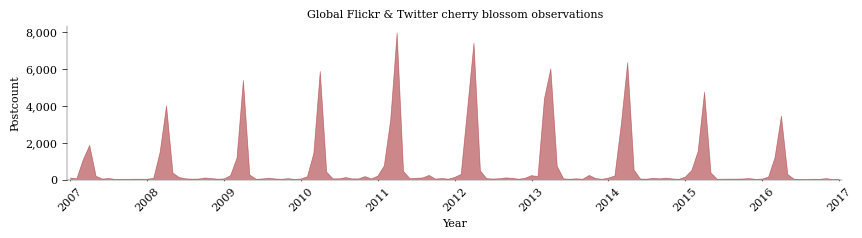

In [542]:
fig, ax = load_and_plot(FLICKR_CHERRY_ALL, src_ref=f"Global Flickr & Twitter cherry blossom observations", agg_base=AGG_BASE, trend=False, metric=metric_col, return_fig_ax=True)
fig.show()

## Twitter

In [543]:
src = Path.cwd().parents[0] / "00_data" / "twitter" / "2017-04-12_CherryTweetsWorldwide_2007to2017-01-01.csv"

In [544]:
load_twitter_kwargs = {
    "filepath_or_buffer":src,
    "index_col":'datetime', 
    "parse_dates":{'datetime':["timestamp"]},
    # "date_format":'%Y-%m-%d',
    "keep_date_col":'False',
    "usecols":["id", "timestamp"]
}
df = pd.read_csv(**load_twitter_kwargs)

In [545]:
df.drop(columns=['timestamp'], inplace=True)

In [546]:
df.head()

,id
datetime,
2007-01-22 08:49:12,3665663
2007-02-17 20:39:46,5560411
2007-03-13 17:42:45,7462541
2007-03-23 04:40:10,11375161
2007-03-24 01:52:51,11860891


**Aggregate**

In [2]:
val_col = "id"
agg_method = "count"
metric_label="observations"

In [548]:
df_twitter = filter_fill_time(
    df, 2007, 2017, val_col=val_col, agg_base=AGG_BASE, agg_method=agg_method)

In [549]:
df_twitter.rename(columns={val_col: metric_label}, inplace=True)

In [550]:
src_ref="Global Twitter cherry blossom observations"

In [551]:
df_twitter.sum()

observations    1599167
dtype: int64

In [552]:
df_twitter.head()

,observations
datetime,
2007-01-31,2
2007-02-28,1
2007-03-31,14
2007-04-30,64
2007-05-31,3


instantiate a second axis that shares the same x-axis

In [553]:
ax2 = ax.twinx()
ax2.set_zorder(ax.get_zorder() - 1)
ax.patch.set_visible(False)
ax.set_ylabel('Observations Flickr')

Text(19.999999999999993, 0.5, 'Observations Flickr')

In [554]:
fig, ax = plot_time(
        df_twitter, legend=metric_label.capitalize(), color=colors([0.0]),
        title=f'{src_ref}', val_col=metric_label,
        filename=f"temporal_{metric_label}_{src_ref}_absolute", trend=False, agg_base=AGG_BASE, fig=fig, ax=ax2, return_fig_ax=True)
ax2.set_ylabel('Observations Twitter')
ax2.set_title("")

Text(0.5, 1.0, '')

In [555]:
range_patch = mpatches.Patch(
    color=colors([0.0]),
    label='Twitter', alpha=0.4)
obs_patch = mpatches.Patch(
    color=colors([1.0]),
    label='Flickr', alpha=0.9)
legend_entries = [range_patch, obs_patch]
legend_kwds = {
    "bbox_to_anchor": (0.0, 1),
    "loc":'upper left',
    "fontsize":8, "frameon":False,
    "alignment":"left"}
ax2.legend(
            handles=legend_entries, **legend_kwds)

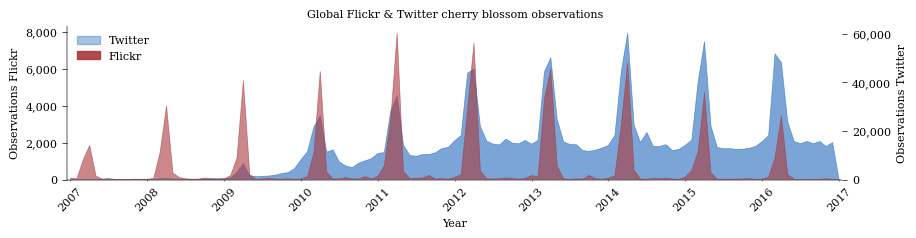

In [556]:
fig

# Create notebook HTML

In [7]:
!jupyter nbconvert --to html_toc \
    --output-dir=../resources/html/ ./04_flickr-cherry.ipynb \
    --output 03_flickr-cherry_{metric_label} \
    --template=../nbconvert.tpl \
    --ExtractOutputPreprocessor.enabled=False >&- 2>&-